# Rotten Tomatoes Reviews
by Stuart Miller  
[Github](https://github.com/sjmiller8182)

**Objective:** Predict 'freshness' of critic review  

[Rotten Tomatoes](https://www.rottentomatoes.com/) rates movies as ['fresh' or 'rotten'](https://www.rottentomatoes.com/about#whatisthetomatometer). A movie is rated a 'fresh' when at least 60% of the critic reviews are positive and rotten when less than 60% of the critic reviews are positive. In some cases, the critics give the movie a numerical or graded rating such as '3/4' or 'A+'. However, in many cases, the critic does not give a rating or grade and the 'freshness' of the review must be inferred from the review. This will be the objective of this project: predicting the freshness of critic reviews.  

Data was previously scraped with [TomatoPy](https://github.com/sjmiller8182/tomatopy). See Data Collection notebook for details.

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import codecs

Load data from file. Open and ignore encoding errors.

In [31]:
data_trans = [[],[],[],[],[],[],[],[]]
with codecs.open('reviews.tsv', "r",encoding='utf-8', errors='ignore')  as fdata:
    for line in fdata:
        data = line.strip().split('\t')
        for i in range(len(data)):
            data_trans[i].append(data[i])

Load data into DataFrame for analysis.

In [32]:
data = pd.DataFrame()
keys = ['id', 'reviews', 'rating', 'fresh', 'critic',
        'top_critic', 'publisher', 'date']

for i in range(len(data_trans)):
    data[keys[i]] = data_trans[i]

## Data Frame Structure
The table contained 7 columns of data and a column of forigen keys. Keys match review data to movie info, which was also scraped.
- id: table forigen key
- reviews: text of critic reviews
- rating: rating
- fresh: freshness of review - fresh or rotten
- critic: critic name
- top_critic: if critic is considered a 'top critic' 1 or 0
- publisher: publisher or review
- date: date of review

Of the 54,432 rows, there are 48,869 reviews and 40,915 ratings. There are 35,379 rows where rating and review is not null. There are no null fresh rows.

In [33]:
data.head()

,id,reviews,rating,fresh,critic,top_critic,publisher,date
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
1,3,It's an allegory in search of a meaning that n...,,rotten,Annalee Newitz,0,io9.com,"May 23, 2018"
2,3,... life lived in a bubble in financial dealin...,,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018"
3,3,"""Continuing along a line introduced in last ye...",,fresh,Daniel Kasman,0,MUBI,"November 16, 2017"
4,3,... a perverse twist on neorealism...,,fresh,,0,Cinema Scope,"October 12, 2017"


In [35]:
data.replace(to_replace = '', value = pd.np.nan, inplace = True)

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54432 entries, 0 to 54431
Data columns (total 8 columns):
id            54432 non-null object
reviews       48869 non-null object
rating        40915 non-null object
fresh         54432 non-null object
critic        51710 non-null object
top_critic    54432 non-null object
publisher     54123 non-null object
date          54432 non-null object
dtypes: object(8)
memory usage: 3.3+ MB


In [40]:
data[(data.reviews.notnull() & data.rating.notnull())].shape

(35379, 8)

## Assessment and Exploration

### Reviews
The reviews will need some preprocessing before using in classification models. The initial preprocessing will be done here. This is just a matter of converting all the words to lower case and removing all the punctuation.

In [245]:
def preprocess_rev(row):
    if 'str' in str(type(row['reviews'])):
        punc = ['~','!','`',',',':',';','"',"'",'.','/',
                '\\','[',']','(',')','&','%','-','_','+','=']
        rev = row['reviews'].lower().strip()
        for p in punc:
            rev = rev.replace(p,'')
        return rev
    else:
        return np.nan

data['review_pp'] = data.apply(preprocess_rev, axis = 1)

In [257]:
print('Sample original review:')
print(list(data['reviews'])[10])

print('\nSample modified review:')
print(list(data['review_pp'])[10])

Sample original review:
"Cosmopolis"" is a hypnotic examination of our modern anxieties about the dehumanization brought on by wealth, power, and technology."

Sample modified review:
cosmopolis is a hypnotic examination of our modern anxieties about the dehumanization brought on by wealth power and technology


### Ratings
Ratings can be given as numerical or as a grade. Since this is a classification task, the numerical values should be mapped to grades. Then the grades can be one-hot encoded is common for classification labeling.

In addition to the mapping, some of these values need to be corrected. For instance, some of the catpured ratings are non-grade letters like 'N' and some are numerical values but do not indicate scale.

In [85]:
np.unique(list(data[data.rating.notnull()].rating))

array(['0', '0.5/10', '0.5/4', '0.5/5', '0/10', '0/4', '0/5', '0/6', '1',
       '1-5', '1.0', '1.0/4', '1.0/5', '1.5', '1.5/10', '1.5/4', '1.5/5',
       '1.6/5', '1.7', '1.8', '1.9/5', '1/10', '1/2', '1/4', '1/5', '1/6',
       '2', '2.0/4', '2.0/5', '2.1/2', '2.2', '2.2/5', '2.3/10', '2.3/4',
       '2.3/5', '2.4/5', '2.5', '2.5/10', '2.5/4', '2.5/5', '2.6/5',
       '2.6/6', '2.7', '2.7/5', '2/10', '2/2', '2/4', '2/5', '2/6', '3',
       '3 1/2', '3.0', '3.0/10', '3.0/4', '3.0/5', '3.1', '3.1/5', '3.2',
       '3.3', '3.3/5', '3.4', '3.5', '3.5/10', '3.5/4', '3.5/5', '3.6/5',
       '3.7', '3.7/5', '3.8/10', '3.8/5', '3/10', '3/2', '3/4', '3/5',
       '3/6', '4', '4.0', '4.0/10', '4.0/4', '4.0/5', '4.1', '4.1/10',
       '4.2', '4.2/10', '4.2/5', '4.3/10', '4.3/5', '4.4/5', '4.5',
       '4.5/10', '4.5/5', '4.7', '4.8', '4.9', '4.9/10', '4/10', '4/4',
       '4/5', '4/6', '5', '5.0/10', '5.0/5', '5.2', '5.5/10', '5.5/5',
       '5.8', '5.8/10', '5.9', '5.9/10', '5/10', '5/4', '5/5

In [161]:
grades = ['A+', 'A', 'A-', 'B+', 'B', 'B-', 'C+', 'C', 'C-',
       'D+', 'D', 'D-', 'F+', 'F', 'F-']
rotten_count = list()
fresh_count = list()

for grade in grades:
    total = (data[data['rating'] == grade]['fresh'] == 'fresh').count()
    fresh = (data[data['rating'] == grade]['fresh'] == 'fresh').sum()
    rotten = total-fresh
    
    rotten_count.append(rotten)
    fresh_count.append(fresh)

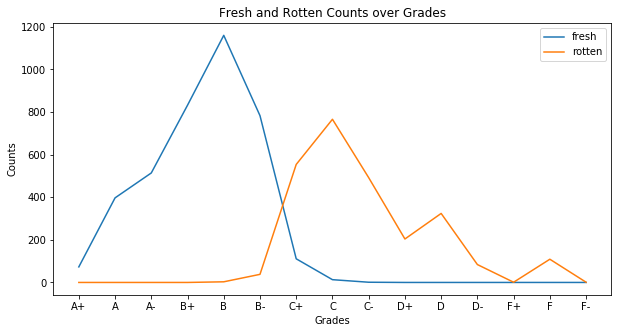

In [180]:
x = [_ for _ in range(len(grades))]

fig, ax = plt.subplots(figsize = (10,5))
ax.plot(x,fresh_count, label = 'fresh');
ax.plot(x,rotten_count, label = 'rotten');
ax.set_title("Fresh and Rotten Counts over Grades");
ax.set_ylabel('Counts')
ax.set_xlabel('Grades')
ax.set_xticks(x)
ax.set_xticklabels(grades)
ax.legend();

### Ratings Mapping
Based on the graph of fresh and rotten counts over the grades given by critics, the cross over point appears to be between B- and C-. I will map B- to 0.6, which is the minimum positive rating. The other numerical ratings will be mapped to grades as shown below.

| Grade | Numerical | Grade | Numerical | Grade | Numerical | Grade | Numerical | Grade | Numerical |
|-------|-----------|-------|-----------|-------|-----------|-------|-----------|-------|-----------|
| A+    | 1         | B+    | 0.76      | C+    | 0.52      | D+    | 0.28      | F+    | 0.04      |
| A     | 0.92      | B     | 0.68      | C     | 0.44      | D     | 0.2       | F     | 0         |
| A-    | 0.84      | B-    | 0.6       | C-    | 0.36      | D-    | 0.12      | F-    | 0         |

In [221]:
def map_numbers_to_grades(num):
    if num == np.nan:
        return np.nan
    else:
        if num == 1:
            return 'A+'
        elif num < 1 and num >= 0.92:
            return 'A'
        elif num < 0.92 and num >= 0.84:
            return 'A-'
        elif num < 0.84 and num >= 0.76:
            return 'B+'
        elif num < 0.76 and num >= 0.68:
            return 'B'
        elif num < 0.68 and num >= 0.6:
            return 'B-'
        elif num < 0.6 and num >= 0.52:
            return 'C+'
        elif num < 0.52 and num >= 0.44:
            return 'C'
        elif num < 0.44 and num >= 0.36:
            return 'C-'
        elif num < 0.36 and num >= 0.28:
            return 'D+'
        elif num < 0.28 and num >= 0.2:
            return 'D'
        elif num < 0.2 and num >= 0.12:
            return 'D-'
        elif num < 0.12 and num >= 0.04:
            return 'F+'
        else:
            return 'F'

def clean_ratings(row):
    if row['rating'] in grades:
        return row['rating']
    else:
        if row['rating'] in ['T','R','N']:
            return np.nan
        elif '-' in str(row['rating']):
            a = row['rating'].split('-')[0]
            b = row['rating'].split('-')[1]
            return map_numbers_to_grades(float(a)/float(b))
        elif ' ' in str(row['rating']):
            a = row['rating'].split(' ')[0]
            b = row['rating'].split(' ')[1]
            if '/' in b:
                b = float(b.split('/')[0])/float(b.split('/')[0])
            a = (float(a) + b)/5
            return map_numbers_to_grades(a)
        elif '/' in str(row['rating']):
            a = row['rating'].split('/')[0]
            b = row['rating'].split('/')[1]
            return map_numbers_to_grades(float(a)/float(b))
        elif float(row['rating']) > 5:
            return map_numbers_to_grades(float(row['rating'])/10.0)
        elif float(row['rating']) < 5 and float(row['rating']) < 1:
            if row['fresh'] == 'fresh':
                return map_numbers_to_grades(float(row['rating'])/(float(row['rating'])+1))
            else:
                return map_numbers_to_grades(float(row['rating'])/(float(row['rating'])+3))
        else:
            return np.nan

In [222]:
data['grade'] = data.apply(clean_ratings, axis = 1)

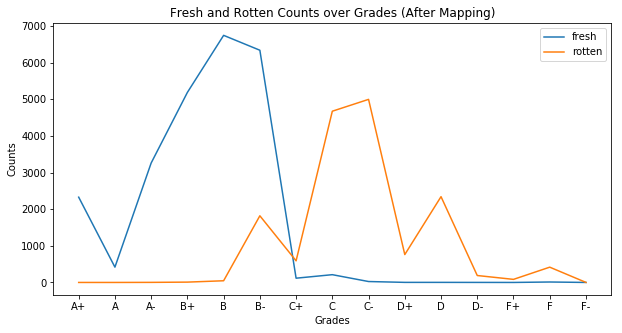

In [229]:
grades = ['A+', 'A', 'A-', 'B+', 'B', 'B-', 'C+', 'C', 'C-',
       'D+', 'D', 'D-', 'F+', 'F', 'F-']
rotten_count = list()
fresh_count = list()

for grade in grades:
    total = (data[data['grade'] == grade]['fresh'] == 'fresh').count()
    fresh = (data[data['grade'] == grade]['fresh'] == 'fresh').sum()
    rotten = total-fresh
    
    rotten_count.append(rotten)
    fresh_count.append(fresh)
    
x = [_ for _ in range(len(grades))]

fig, ax = plt.subplots(figsize = (10,5))
ax.plot(x,fresh_count, label = 'fresh');
ax.plot(x,rotten_count, label = 'rotten');
ax.set_title("Fresh and Rotten Counts over Grades (After Mapping)");
ax.set_ylabel('Counts')
ax.set_xlabel('Grades')
ax.set_xticks(x)
ax.set_xticklabels(grades)
ax.legend();

After mapping the ratings to grades, it looks like there is some noise near the cross over point. I will leave it like this. Some noise near the cross over area is to be expected. It is possilbe that Rotten Tomatoes has miss classified some of these ratings.

## Review Modeling
I am planning on using two models:
- Naive Bayes
- Multilayer Perception

why these models?

**Review Labeling:** There are two way to label the reviews with this dataset. 
1. Label the reviews based on the fresh column.
2. Label the reivews based on the critic rating.

I plan on doing the second option. This would be the normal application of this kind of modeling. A model would be trained on reviews where the critic gave a text review and a numerical or graded rating. Then the model would be used to classify ratings where the critics did not provide numerical or grading ratings.

Do this, I first need to map graded rating to numerical equivalents and convert the ratings column to a numerical data type. The ratings given as fractions will be treated as fractions and the grades will have to be mapped.

In [158]:
(data[data['rating'] == 'F']['fresh'] == 'fresh').sum()

0

In [131]:
data[data['rating'] == 'F']

,id,reviews,rating,fresh,critic,top_critic,publisher,date
42,3,If you pay even a single penny to watch the th...,F,rotten,Erick Weber,0,NECN,"August 24, 2012"
1524,45,NaN,F,rotten,Owen Gleiberman,1,Entertainment Weekly,"September 7, 2011"
1531,45,NaN,F,rotten,NaN,1,Entertainment Weekly,"March 27, 1998"
4112,145,NaN,F,rotten,NaN,1,Entertainment Weekly,"April 18, 1997"
4770,165,"When the big revelations come at the end, they...",F,rotten,Frank Swietek,0,One Guy's Opinion,"February 2, 2001"
5185,196,"Mean-spirited, unpleasant comedy about charact...",F,rotten,Eric D. Snider,0,EricDSnider.com,"April 30, 2005"
5208,196,You'll feel like the one who's being held host...,F,rotten,NaN,0,E! Online,"April 23, 2005"
5214,196,"I looked at the ceiling, not casting my eyes h...",F,rotten,Nell Minow,0,Movie Mom,"April 21, 2005"
6276,235,It's almost like [Scott]'s trying as hard as h...,F,rotten,Chuck Rudolph,0,Matinee Magazine,"January 1, 2000"
6345,242,NaN,F,rotten,Owen Gleiberman,1,Entertainment Weekly,"September 7, 2011"


In [ ]:
from sklearn.model_selection import train_test_split
data

X_train, X_test, y_train, y_test = train_test_split(data['sms_message'], 
                                                    data['label'], 
                                                    random_state=1)

### Naive Bayes Model 
- First use `CountVectorizer` to extract features from the reviews and vectorize the reviews.
- Train Naive Bayes model (`MultinomialNB`) on vectorized reviews

In [43]:

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
nb_random_state = 49

In [ ]:
count_vec = CountVectorizer()
